In [299]:
import pandas as pd
import re
import numpy as np
from time import time 
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from wordcloud import WordCloud
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from spacy.lang.es.stop_words import STOP_WORDS
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from spacy.lang.es import Spanish
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import es_core_news_sm
import networkx as nx
import seaborn as sns
import chart_studio.plotly as py
import spacy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/miniconda3/envs/py366/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['datetime', 'time', 'seed']
`%matplotlib` prevents importing * from pylab and numpy



In [300]:
tweets_user = pd.read_csv('/Users/Noelia/Desktop/DATA_IRONHACK/FINAL_PROJECT/final_project_ironhack/output/User_csv/@Noelia_Carrion9_tweets.csv')

In [301]:
tweets_user.head()

id           created_at  \
0  1156508893893275648  2019-07-31 10:16:21   
1  1156508767934136321  2019-07-31 10:15:51   
2  1156508688506589184  2019-07-31 10:15:32   
3  1156508626317656067  2019-07-31 10:15:18   
4  1156508475406635008  2019-07-31 10:14:42   

                                                text  
0  RT @voz_populi: Podemos e IU denuncian a ocho ...  
1  RT @MujeresRtve: Nuestro pesar por la muerte d...  
2  RT @elespanolcom: #Investigación | Científicos...  
3  RT @TheObjective_es: En la primera de las cuat...  
4  RT @eldiarioes: "Afilando los cuchillos": iLe ...

In [302]:
def retweet(input_text):
    if input_text.startswith("RT"):
        value = 1
    else:
        value = 0
    return value

In [303]:
tweets_user['RT'] = tweets_user.text.apply(retweet)

In [304]:
tweets_user['mention'] = tweets_user.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

In [305]:
tweets_user['hashtag'] = tweets_user.text.str.extract(r'(\#\w+)', expand=False)

In [306]:
tweets_user['hashtag'] = tweets_user['hashtag'].fillna("")

In [307]:
tweets_user['date'] = tweets_user['created_at']

In [308]:
tweets_user['date'] = pd.DatetimeIndex(tweets_user['created_at']).to_period('D')

In [309]:
tweets_user = tweets_user.drop(columns=["created_at"], axis=1)

In [310]:
nlp = es_core_news_sm.load(parser=True)

In [311]:
#nlp = spacy.load('es', parser=True)

In [312]:
nlp.Defaults.stop_words |= {"RT","próx", "xd", "rt", "htt", "parir", "sobrar", "the", "and"}

In [313]:
def spacy_tokenizer(sentence):
    sentence = re.sub(r'htt\S+', '', sentence)
    tokens = nlp(sentence)
    filtered_tokens = []
    for word in tokens:
        lemma = word.lemma_.lower().strip()
        
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]{2}\w+', lemma):
            filtered_tokens.append(lemma)

    return filtered_tokens

In [314]:
tweets_user['tokenized'] = tweets_user['text'].apply(spacy_tokenizer)

In [315]:
num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

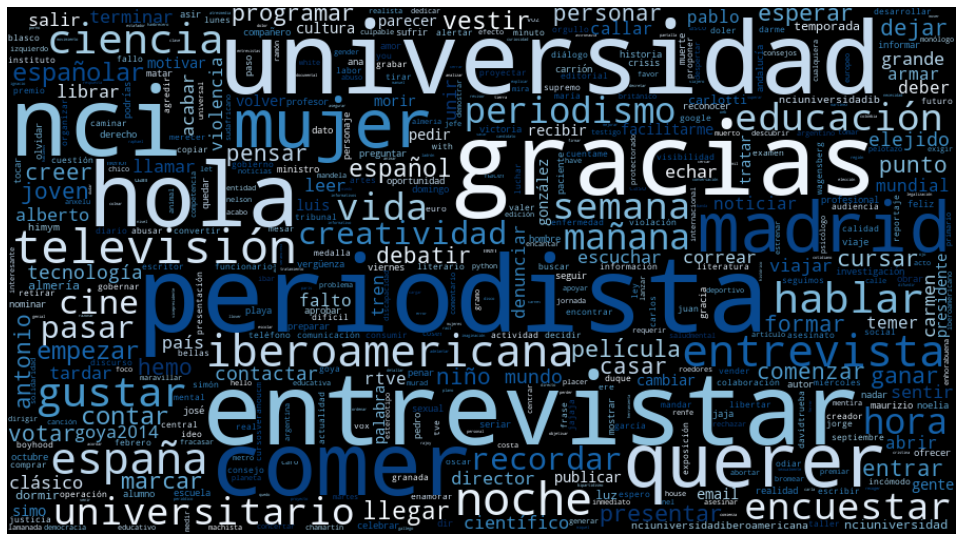

In [316]:
all_words = []
for line in tweets_user['tokenized']: 
    all_words.extend(line)
    
wordfreq = Counter(all_words)
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [349]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3).fit(tweets_user['text'].values)

In [351]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(tweets_user['text'].values)
#tfidf_matrix = tfidf_vectorizer.transform(tweets_colega['text'].values)

print(tfidf_matrix.shape)

CPU times: user 6.04 s, sys: 28 ms, total: 6.07 s
Wall time: 6.08 s
(641, 302)


In [352]:
terms = tfidf_vectorizer.get_feature_names()

In [353]:
array_matrix = tfidf_matrix.toarray()

In [354]:
first_vector_tfidfvectorizer=tfidf_matrix[0]
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head()

tfidf
operación                     0.603894
denunciar                     0.563610
ministro                      0.563610
abrir                         0.000000
nciuniversidadiberoamericana  0.000000

vocab = tfidf_vectorizer.vocabulary_

dist = 1 - cosine_similarity(tfidf_matrix)
dist

In [355]:
umap = UMAP(n_components=2, n_neighbors=5, random_state=42).fit(tfidf_matrix)
embedding = umap.fit_transform(tfidf_matrix)

# tweets from your colega
#embedding_colega = umap.transform(tfidf_matrix_colega)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)



In [356]:
umap_df = pd.DataFrame(embedding, columns=[f'emb_{i+1}' for i in range(2)])

In [357]:
umap_df.head()

emb_1      emb_2
0  29.981638  10.785851
1  32.279999  15.953525
2  33.970703  17.168734
3  33.181263  17.358833
4  28.613844   9.995460

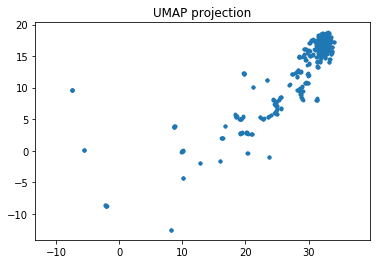

In [358]:
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], cmap='Spectral', s=8)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection', fontsize=12);

In [359]:
hdbscan = HDBSCAN(min_cluster_size=20, prediction_data=True)
clustering = hdbscan.fit_predict(embedding)
np.unique(clustering)

array([-1,  0,  1,  2,  3,  4,  5])

In [29]:
labels = hdbscan.labels_

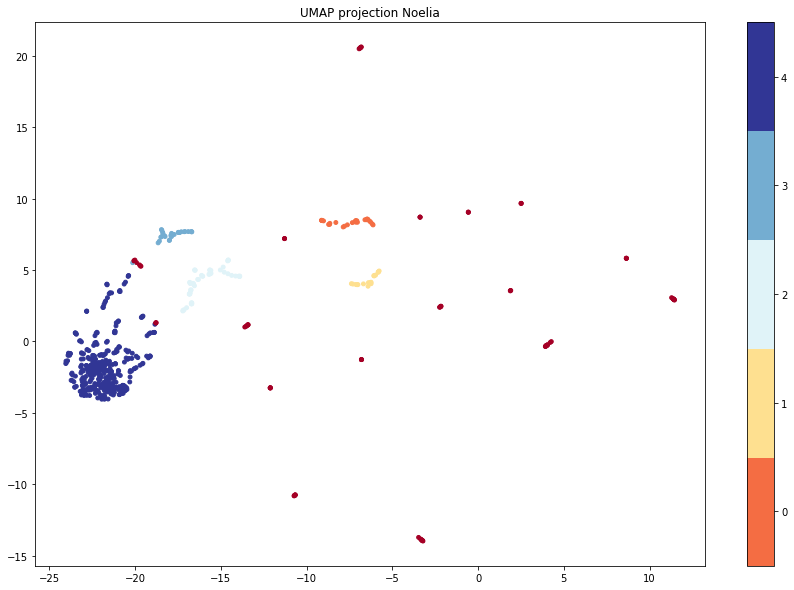

In [30]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], c =labels, cmap='RdYlBu', s=15)
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection Noelia', fontsize=12);

In [31]:
tweets = {'tweet': tweets_user['text'].values, "words": tweets_user['tokenized'].values, 'cluster': labels, "mention": tweets_user['mention'].values, "RT": tweets_user['RT'].values, "date": tweets_user['date'].values}
cluster_user = pd.DataFrame(tweets, columns = ['tweet', 'words', "cluster", "mention", "RT", "date"])

In [32]:
cluster_user[cluster_user['cluster']==0].head()

tweet  \
28   RT @NachoCarretero: Pablo Ibar ha sido declara...   
35   @Miguel__Lorente escribe y recuerda que mientr...   
44   Hoy hemos entrevistado a @ViolaSofia para @NCI...   
98   RT @NCINoticias: Su hija, su marido, su antigu...   
118  RT @magcedonia: Somos las travestis\nSomos las...   

                                                 words  cluster  \
28   [pablo, ibar, declarar, culpable, probar, adn,...        0   
35   [escribir, recordar, mujer, tomar, medir, prot...        0   
44   [hemo, entrevistar, noche, abrir, concertar, m...        0   
98   [hijo, maridar, antiguo, psicólogo, jefe, pers...        0   
118  [travesti, marica, bollero, loco, pluma, recue...        0   

                                 mention  RT        date  
28                        NachoCarretero   1  2019-01-19  
35                       Miguel__Lorente   0  2018-12-18  
44   ViolaSofia, NCINoticias, monlaferte   0  2018-11-08  
98           NCINoticias, gabrielawiener   1  2018-07-23  
118                           magcedonia   1  2018-06-28

In [33]:
cluster_user = cluster_user.reset_index(drop=True)

In [34]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df.head()

abrir  abusar  acabar  actividad  actualidad  agredir  alberto  almería  \
0  0.000000     0.0     0.0        0.0         0.0      0.0      0.0      0.0   
1  0.409703     0.0     0.0        0.0         0.0      0.0      0.0      0.0   
2  0.000000     0.0     0.0        0.0         0.0      0.0      0.0      0.0   
3  0.000000     0.0     0.0        0.0         0.0      0.0      0.0      0.0   
4  0.000000     0.0     0.0        0.0         0.0      0.0      0.0      0.0   

   alumno  amor  ...  viernes  violación  violencia  visibilidad  visitar  \
0     0.0   0.0  ...      0.0        0.0        0.0          0.0      0.0   
1     0.0   0.0  ...      0.0        0.0        0.0          0.0      0.0   
2     0.0   0.0  ...      0.0        0.0        0.0          0.0      0.0   
3     0.0   0.0  ...      0.0        0.0        0.0          0.0      0.0   
4     0.0   0.0  ...      0.0        0.0        0.0          0.0      0.0   

   volver  votar  vox  wagensberg  you  
0     0.0    0.0  0.0         0.0  0.0  
1     0.0    0.0  0.0         0.0  0.0  
2     0.0    0.0  0.0         0.0  0.0  
3     0.0    0.0  0.0         0.0  0.0  
4     0.0    0.0  0.0         0.0  0.0  

[5 rows x 303 columns]

In [35]:
def get_df_from_cluster(cluster):
    return tfidf_df[clustering==cluster]

In [36]:
top_words_cluster = get_df_from_cluster(1).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head(10)

cursar         4.332891
comenzar       4.246039
creatividad    3.825782
viajar         3.479835
audiencia      2.249846
maurizio       2.052430
carlotti       1.988520
televisión     1.769218
garcía         1.427906
alberto        1.296442
dtype: float64

In [37]:
umap3d = UMAP(n_components=3, n_neighbors=5, random_state=42)
embedding3d = umap3d.fit_transform(tfidf_matrix)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


In [38]:
umap_df3d = pd.DataFrame(embedding3d, columns=[f'emb_{i+1}' for i in range(3)])

umap_df3d.head()

emb_1      emb_2     emb_3
0 -0.232353  24.211349  3.019415
1  1.301094  24.696087  2.417607
2 -0.418421  25.900331  3.600581
3 -0.279918  24.327360  2.909113
4  3.172856  19.433201 -3.610716

In [39]:
import plotly.express as px
#iris = px.data.iris()
fig = px.scatter_3d(umap_df3d, x='emb_1', y='emb_2', z='emb_3',
              color='emb_3', size_max=20,
            opacity=0.7)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [40]:
tweets_friend = pd.read_csv('/Users/Noelia/Desktop/DATA_IRONHACK/FINAL_PROJECT/final_project_ironhack/output/User_csv/@virginiagruul_tweets.csv')

In [41]:
tweets_friend['RT'] = tweets_friend.text.apply(retweet)

In [42]:
tweets_friend['mention'] = tweets_friend.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

In [43]:
tweets_friend['hashtag'] = tweets_friend.text.str.extract(r'(\#\w+)', expand=False)

In [44]:
tweets_friend['hashtag'] = tweets_friend['hashtag'].fillna("")

In [45]:
tweets_friend['date'] = tweets_friend['created_at']

In [46]:
tweets_friend = tweets_friend.drop(columns=["created_at"], axis=1)

In [191]:
tweets_friend['tokenized'] = tweets_friend['text'].apply(spacy_tokenizer)

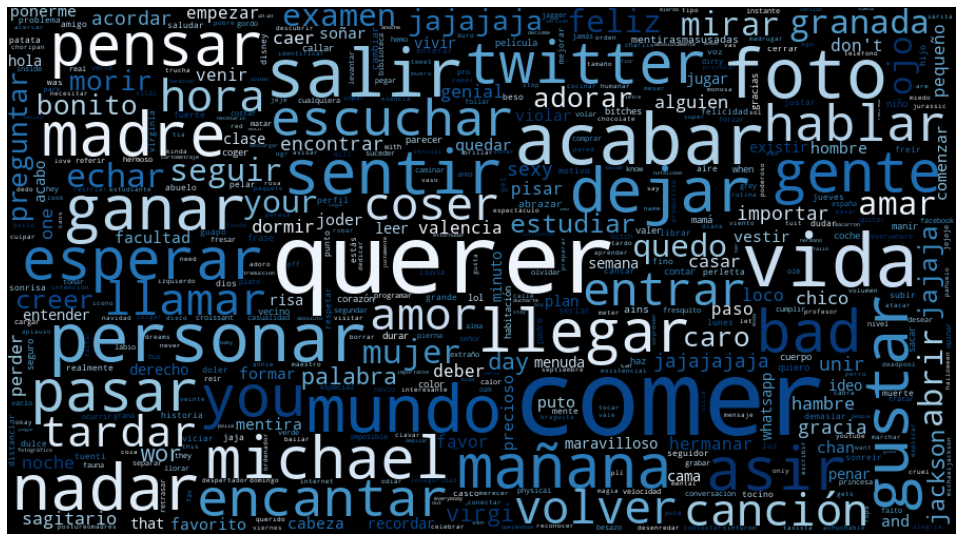

In [192]:
num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

all_words = []
for line in tweets_friend['tokenized']: 
    all_words.extend(line)
    
wordfreq = Counter(all_words)
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [56]:
tfidf_vectorizer_friends = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3)

%time tfidf_matrix_friends = tfidf_vectorizer_friends.fit_transform(tweets_friend['text'].values)


CPU times: user 13.5 s, sys: 41.6 ms, total: 13.5 s
Wall time: 13.5 s


In [227]:
print(tfidf_matrix_friends.shape)

(3209, 1741)


In [61]:
array_matrix_friend = tfidf_matrix_friends.toarray()

In [62]:
first_vector_tfidfvectorizer_friend=tfidf_matrix_friends[0]
df_friend = pd.DataFrame(first_vector_tfidfvectorizer_friend.T.todense(), index=tfidf_vectorizer_friends.get_feature_names(), columns=["tfidf"])
df_friend.sort_values(by=["tfidf"],ascending=False).head()

tfidf
mesar       1.0
abrazar     0.0
pequeño     0.0
penar       0.0
película    0.0

In [64]:
embedding_friend = umap.fit_transform(array_matrix_friend)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)



In [65]:
umap_df_friend = pd.DataFrame(embedding_friend, columns=[f'emb_{i+1}' for i in range(2)])
umap_df_friend.head()


emb_1      emb_2
0  12.600778  10.830004
1  14.645748   9.148510
2  12.787535  12.114673
3  14.781781   0.734060
4  14.041811   0.836081

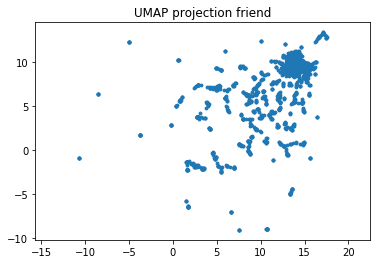

In [66]:
plt.scatter(umap_df_friend['emb_1'], umap_df_friend['emb_2'], cmap='Spectral', s=8)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection friend', fontsize=12);


In [80]:
hdbscan

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=20, min_samples=None, p=None,
        prediction_data=True)

In [98]:
#hdbscan = HDBSCAN(min_cluster_size=20, prediction_data=True)
#clustering = hdbscan.fit_predict(embedding)
#np.unique(clustering)

In [ ]:
data = np.load('clusterable_data.npy')
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, prediction_data=True).fit(data) 

pal = sns.color_palette('deep', 8)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_,
plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds);

In [140]:
clusterer = HDBSCAN(min_cluster_size=15, prediction_data=True).fit(embedding)

In [159]:
umap_df_friend = pd.DataFrame(embedding_friend, columns=[f'emb_{i+1}' for i in range(2)])

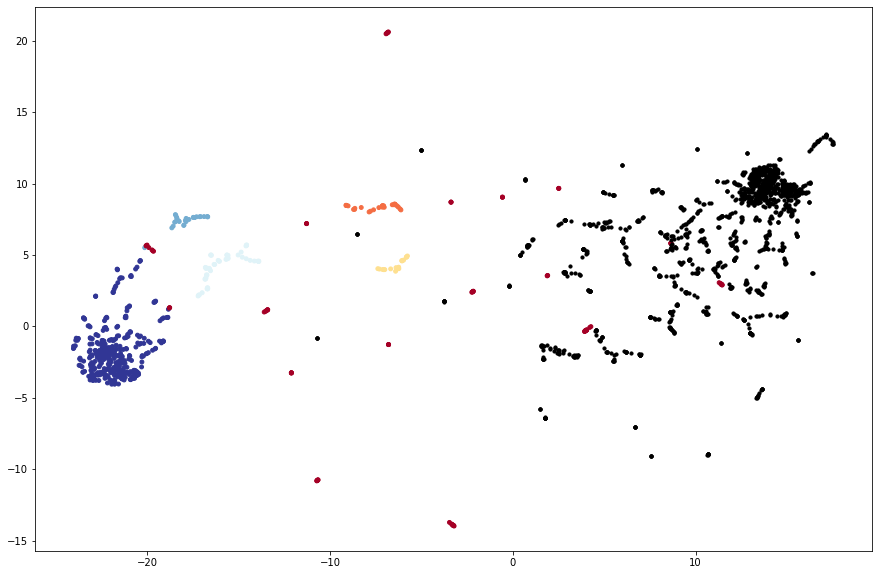

In [165]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], c =labels, cmap='RdYlBu', s=15)
plt.scatter(umap_df_friend['emb_1'],umap_df_friend['emb_2'], c='k', s=10)

In [180]:
tweets_friend_2= pd.read_csv('/Users/Noelia/Desktop/DATA_IRONHACK/FINAL_PROJECT/final_project_ironhack/output/User_csv/@ramonlobo_tweets.csv')

In [181]:
tweets_friend_2['RT'] = tweets_friend_2.text.apply(retweet)

In [182]:
tweets_friend_2['mention'] = tweets_friend_2.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

In [183]:
tweets_friend_2['hashtag'] = tweets_friend_2.text.str.extract(r'(\#\w+)', expand=False)

In [184]:
tweets_friend_2['hashtag'] = tweets_friend_2['hashtag'].fillna("")

In [185]:
tweets_friend_2['date'] = tweets_friend_2['created_at']

In [186]:
tweets_friend_2 = tweets_friend_2.drop(columns=["created_at"], axis=1)

In [196]:
tweets_friend_2['tokenized'] = tweets_friend_2['text'].apply(spacy_tokenizer)

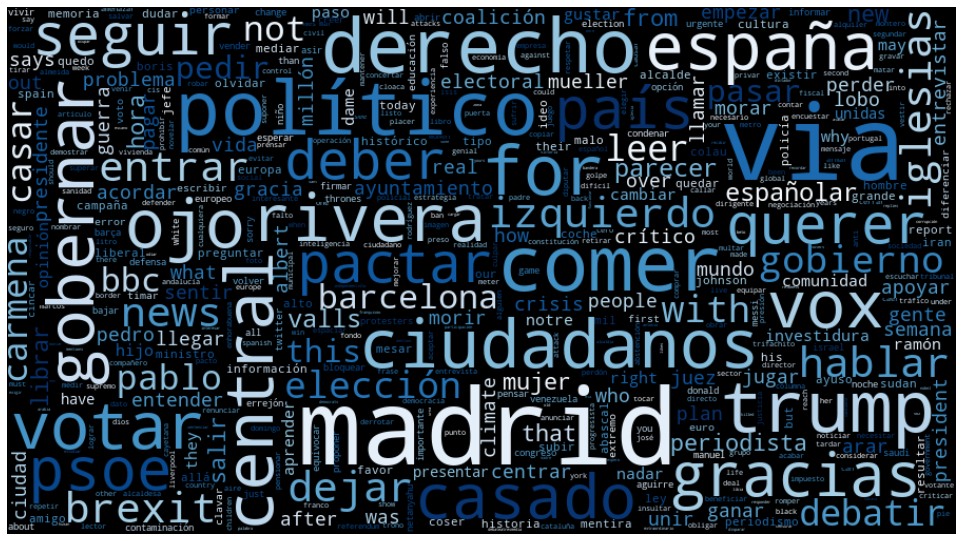

In [197]:
num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

all_words = []
for line in tweets_friend_2['tokenized']: 
    all_words.extend(line)
    
wordfreq = Counter(all_words)
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [360]:
#tfidf_vectorizer_friends_2 = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3)
%time tfidf_matrix_friends_2 = tfidf_vectorizer.fit_transform(tweets_friend_2['text'].values)

CPU times: user 27.9 s, sys: 77 ms, total: 28 s
Wall time: 28 s


In [361]:
print(tfidf_matrix_friends_2.shape)

(3209, 1741)


In [362]:
array_matrix_friend_2 = tfidf_matrix_friends_2.toarray()

In [363]:
first_vector_tfidfvectorizer_friend_2=tfidf_matrix_friends_2[0]
df_friend_2 = pd.DataFrame(first_vector_tfidfvectorizer_friend_2.T.todense(), index=tfidf_vectorizer_friends_2.get_feature_names(), columns=["tfidf"])
df_friend_2.sort_values(by=["tfidf"],ascending=False).head()

tfidf
may       0.494041
that      0.460406
language  0.295460
die       0.295460
lives     0.295460

In [364]:
umap = UMAP(n_components=2, n_neighbors=5, random_state=42).fit(tfidf_matrix)
embedding = umap.fit_transform(tfidf_matrix)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)



In [365]:
embedding_friend_2 = umap.fit_transform(array_matrix_friend_2)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:182: UserWarning:

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!



In [366]:
umap_df_friend_2 = pd.DataFrame(embedding_friend_2, columns=[f'emb_{i+1}' for i in range(2)])
umap_df_friend_2.head()

emb_1      emb_2
0  8.940450  -9.016569
1  9.589055 -12.470027
2  7.860819  -8.873739
3  8.162119  -9.390450
4  9.400769  -9.844628

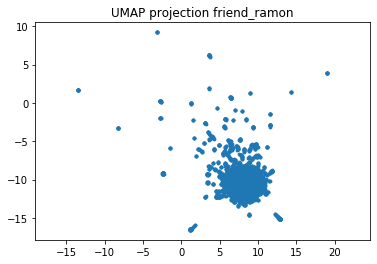

In [367]:
plt.scatter(umap_df_friend_2['emb_1'], umap_df_friend_2['emb_2'], cmap='Spectral', s=8)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection friend_ramon', fontsize=12);


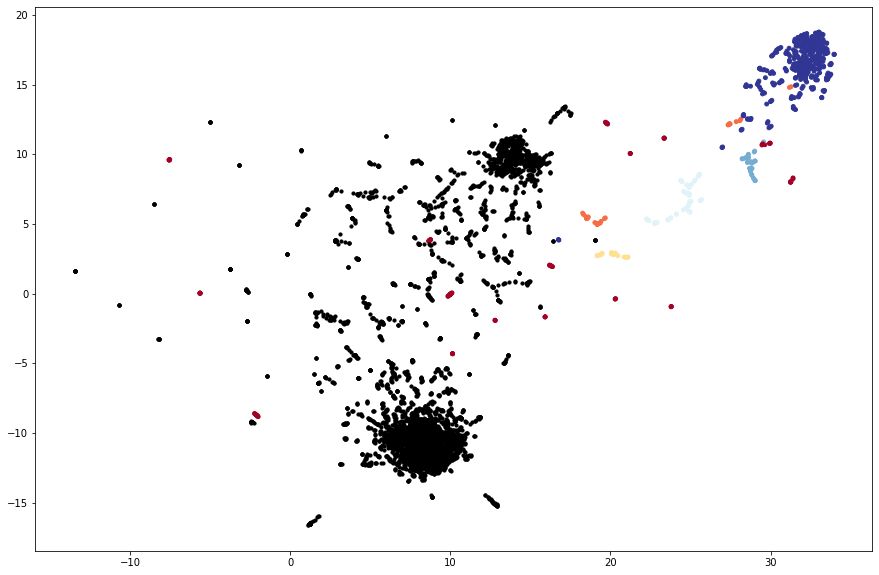

In [368]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], c =labels, cmap='RdYlBu', s=15)
plt.scatter(umap_df_friend_2['emb_1'],umap_df_friend_2['emb_2'], c='k', s=10)
plt.scatter(umap_df_friend['emb_1'],umap_df_friend['emb_2'], c='k', s=10)

In [213]:
tweets_ramon = {'tweet': tweets_friend_2['text'].values, "words": tweets_friend_2['tokenized'].values, "mention": tweets_friend_2['mention'].values, "RT": tweets_friend_2['RT'].values, "date": tweets_friend_2['date'].values}
cluster_ramon = pd.DataFrame(tweets_ramon, columns = ['tweet', 'words', "cluster", "mention", "RT", "date"])

In [220]:
cluster_ramon[['words']].head()

words
0  [die, that, may, meaning, life, but, language,...
1  [madrid, montar, estructurar, ilícito, permane...
2  [toni, morrison, nobel, laureate, who, transfi...
3  [eta, responder, estrategia, utilizan, dolor, ...
4                                          [igualar]

In [ ]:
plt.scatter(*test_points.T, c='k', s=50)

In [146]:
test_labels, strengths = HDBSCAN.approximate_predict(clusterer, embedding_friend)
test_labels

AttributeError: type object 'HDBSCAN' has no attribute 'approximate_predict'

In [ ]:
test_labels, strengths = hdbscan.approximate_predict(clusterer, test_points)
test_labels

In [158]:
clusterer.generate_prediction_data()

In [155]:
embedding_friend.shape

(1569, 2)

In [143]:
test_labels, strengths = clusterer.approximate_predict(clusterer, test_points)
test_labels

AttributeError: 'HDBSCAN' object has no attribute 'approximate_predict'

In [116]:
model = hdbscan.HDBSCAN(prediction_data=True).fit(embedding)
labels, membership_strengths = hdbscan.approximate_predict(model, embedding_friend)

AttributeError: 'HDBSCAN' object has no attribute 'HDBSCAN'

In [110]:
hdbscan = HDBSCAN(prediction_data=True)
#test_labels, strengths = hdbscan.approximate_predict(clusterer, embedding_friend)

In [104]:
hdbscan.approximate_predict()

AttributeError: 'HDBSCAN' object has no attribute 'approximate_predict'

In [115]:
hdbscan.approximate_predict(hdbscan_, embedding_friend)

AttributeError: 'HDBSCAN' object has no attribute 'approximate_predict'

In [106]:
test_labels, strengths = hdbscan.approximate_predict(hdbscan, embedding_friend)

AttributeError: 'HDBSCAN' object has no attribute 'approximate_predict'

In [69]:
clustering_friend = hdbscan.prediction.approximate_predict(embedding_friend)
np.unique(clustering_friend)

AttributeError: 'HDBSCAN' object has no attribute 'prediction'

In [50]:
cluster_user.to_csv("../output/cluster_user.csv")